# Results Analysis

## Imports

In [2]:
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [3]:
RESULT_DIR  = '../results/'

In [4]:
LOG_FILE = '../experiments/experiments.log'

In [5]:
RESULT_FILES = !find $RESULT_DIR -type f 

#### Strategies

In [6]:
CLASSIC_METHODS = [
    'random_sampling',
    'margin_sampling',
    'training_utility_sampling',
    'density_weighted_sampling',
    'expected_error_reduction'
]

In [7]:
NEIGHBORHOOD = [
    "borderline_points_sampling",
    "k_disagreeing_neighbors_sampling",
    "local_set_cardinality_sampling",
    "ls_radius_sampling",
    "intra_extra_ratio_sampling",
    "harmfulness_sampling",
    "usefulness_sampling"
]

In [8]:
LIKELIHOOD = [
    "class_likelihood_sampling",
    "class_likeliood_diff_sampling",
]

In [9]:
FEATURE_BASED = [
    "f1_sampling",
    "f2_sampling",
    "f3_sampling",
    "f4_sampling",
]

In [10]:
TREE_BASED = [
    "disjunct_class_percentage_sampling",
    "disjunct_size_sampling",
    "tree_depth_pruned_sampling",
    "tree_depth_unpruned_sampling",
]

In [11]:
CLASS_BALANCE = [
    "class_balance_sampling",
    "minority_value_sampling",
]

### Helper Functions

In [12]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC_METHODS,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [13]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC_METHODS:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

### Learning Curves

In [14]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

### Ranking Curves

In [15]:
def plot_ranking_curves(data: pd.DataFrame, model:str):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=True)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                markevery=10)


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')
   

## Data Gathering

In [16]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [17]:
index_columns = ['dataset', 'model', 'strategy']

In [18]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

## Data Analysis

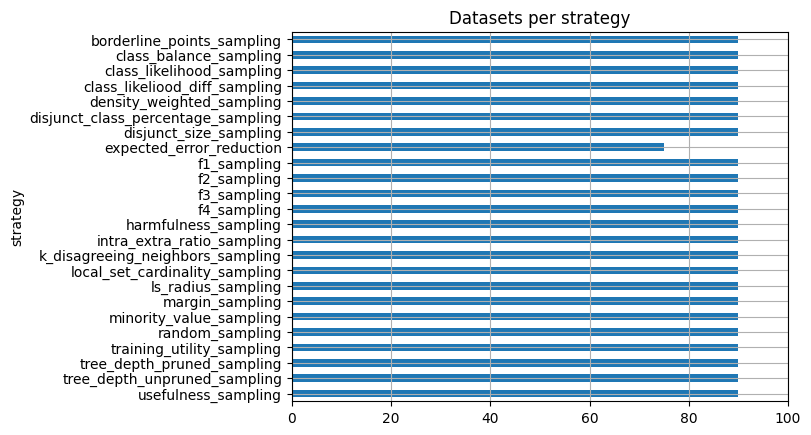

In [22]:
df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
    kind='barh', grid=True, title="Datasets per strategy", xlim=(0,100))
plt.show()

### Learning Curves

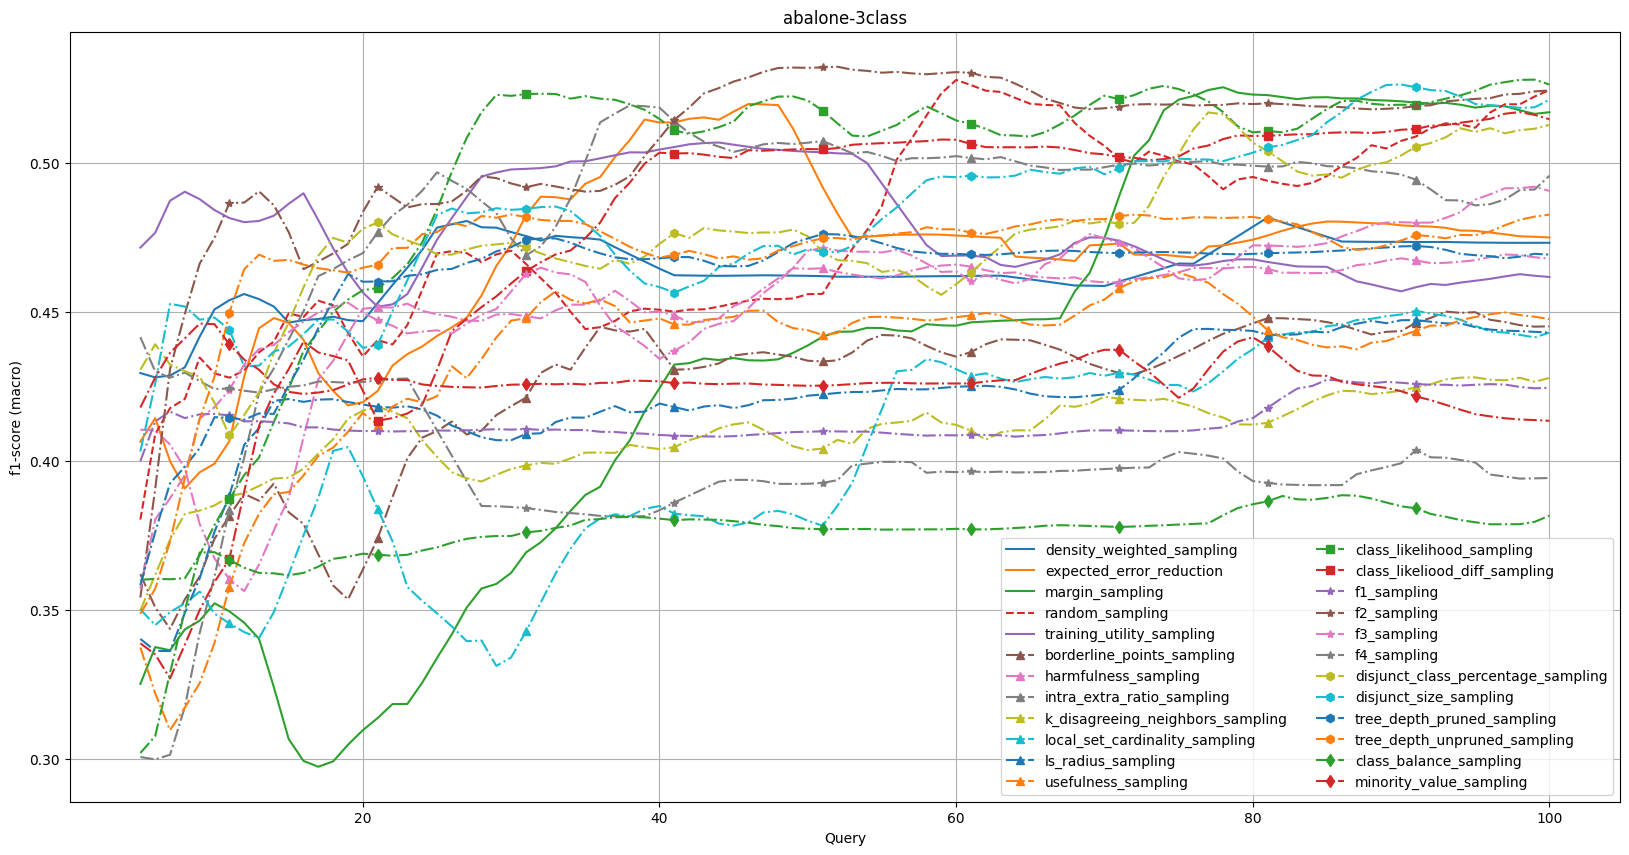

 q


In [26]:
for dataset in df.index.levels[0]:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier='SVC')    
    
    display(plt.gcf())
    if input() == 'q':
        break

    clear_output(wait=True)
    plt.close()
plt.close()

### Ranking Curves

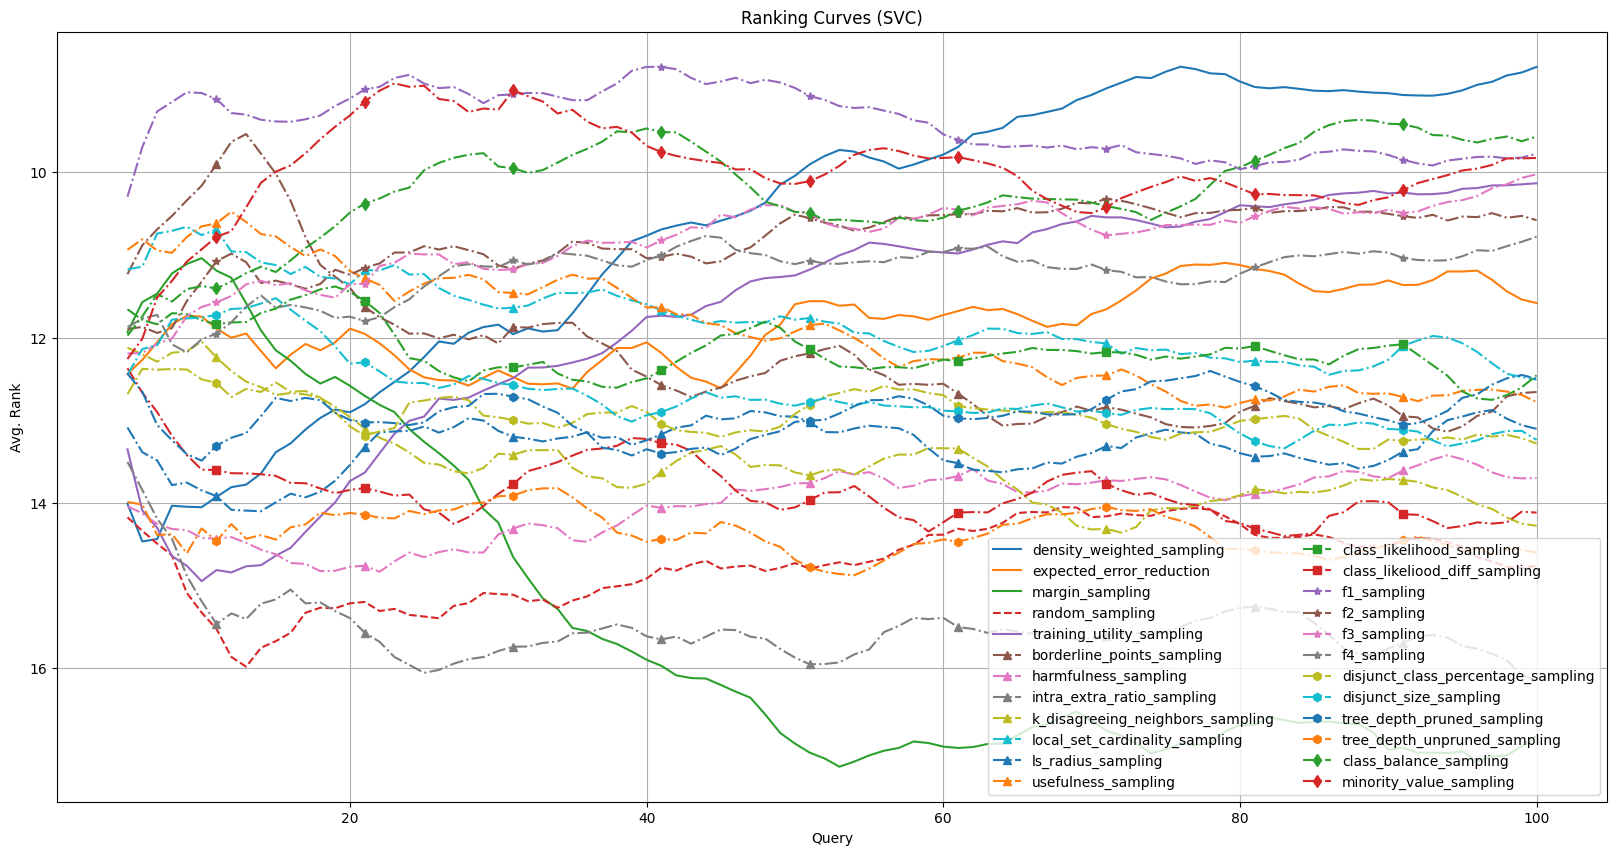

In [27]:
plot_ranking_curves(df, model='SVC')

## Log File

In [28]:
warning_lines = !grep WARNING $LOG_FILE
len(warning_lines)

167620

Produzindo dataframe...

In [29]:
columns = ['time', 'context', 'type', 'msg']
log_df = pd.DataFrame((line.split(' - ') for line in warning_lines),
                     columns=columns)

log_df.context = log_df.context.apply(lambda x: x[1:-1])
log_df[['dataset', 'model', 'strategy']] = log_df.context.str.split(',', expand=True)
log_df.strategy = log_df.strategy.str.strip()

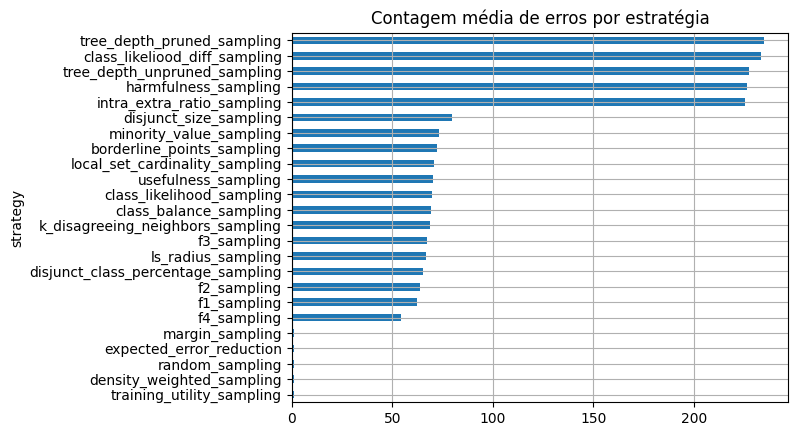

In [30]:
log_df.groupby(['dataset','strategy']).size().groupby('strategy').mean().sort_values().plot(
    kind='barh', grid=True,
    title='Contagem média de erros por estratégia')
plt.show()

In [32]:
log_df.groupby(['dataset','strategy']).size().sort_values(ascending=False)

dataset                         strategy                          
wilt.csv                        class_likeliood_diff_sampling         500
ozone-eighthr.csv               intra_extra_ratio_sampling            500
climate-simulation-craches.csv  intra_extra_ratio_sampling            500
                                harmfulness_sampling                  500
ozone-eighthr.csv               class_likeliood_diff_sampling         500
                                                                     ... 
thyroid-ann.csv                 k_disagreeing_neighbors_sampling        1
volcanoes-e1.csv                disjunct_class_percentage_sampling      1
                                f2_sampling                             1
ecoli.csv                       training_utility_sampling               1
nursery.csv                     training_utility_sampling               1
Length: 1421, dtype: int64

In [ ]:
# plot_learning_curves(df, dataset='wilt', classifier='SVC')

### Hardness Sampling

In [33]:
pd.options.display.max_colwidth = 200
pd.DataFrame(log_df.msg.apply(lambda x: x[x.find(']') + 1:]).value_counts()).reset_index()[['count', 'msg']].head(50)

,count,msg
0,16352,"An error occurred while calculating tree_depth_pruned: (RuntimeWarning) ""invalid value encountered in divide"" . Falling back to random sampling."
1,14798,"An error occurred while calculating tree_depth_unpruned: (RuntimeWarning) ""invalid value encountered in divide"" . Falling back to random sampling."
2,14613,"An error occurred while calculating class_likeliood_diff: (ValueError) ""zero-size array to reduction operation maximum which has no identity"" . Falling back to random sampling."
3,14486,"An error occurred while calculating intra_extra_ratio: (IndexError) ""index 0 is out of bounds for axis 0 with size 0"" . Falling back to random sampling."
4,14419,"An error occurred while calculating harmfulness: (RuntimeWarning) ""divide by zero encountered in divide"" . Falling back to random sampling."
5,2277,"An error occurred while calculating tree_depth_unpruned: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
6,2198,"An error occurred while calculating class_likeliood_diff: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
7,2139,"An error occurred while calculating intra_extra_ratio: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
8,2090,"An error occurred while calculating harmfulness: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
9,2050,"An error occurred while calculating ls_radius: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."


### Classic Methods

In [34]:
log_df[log_df.strategy.apply(lambda x: x in CLASSIC_METHODS)]

,time,context,type,msg,dataset,model,strategy
32070,"2024-06-06 21:43:14,265","lymphography.csv, SVC, random_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,random_sampling
32072,"2024-06-06 21:43:15,547","lymphography.csv, SVC, margin_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,margin_sampling
32073,"2024-06-06 21:43:20,823","lymphography.csv, SVC, density_weighted_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,density_weighted_sampling
32075,"2024-06-06 21:43:22,993","lymphography.csv, SVC, training_utility_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,training_utility_sampling
32077,"2024-06-06 21:43:29,315","lymphography.csv, SVC, expected_error_reduction",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,expected_error_reduction
35642,"2024-06-06 23:19:28,703","nursery.csv, SVC, random_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,random_sampling
35645,"2024-06-06 23:19:44,442","nursery.csv, SVC, margin_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,margin_sampling
35646,"2024-06-06 23:19:51,191","nursery.csv, SVC, density_weighted_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,density_weighted_sampling
35648,"2024-06-06 23:19:53,510","nursery.csv, SVC, training_utility_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,training_utility_sampling
35652,"2024-06-06 23:20:29,557","nursery.csv, SVC, expected_error_reduction",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,expected_error_reduction
